In [8]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib as mpl
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#tutorial followed 
#https://towardsdatascience.com/energy-consumption-time-series-forecasting-with-python-and-lstm-deep-learning-model-7952e2f9a796

In [9]:
holidata = pd.read_pickle('./building4_holidays.pkl')
holidata.head()

,Valeur,Datetime,working day
Date,,,
2018-03-05 00:15:00,4.044,2018-03-05 00:15:00,True
2018-03-05 00:30:00,3.667,2018-03-05 00:30:00,True
2018-03-05 00:45:00,3.567,2018-03-05 00:45:00,True
2018-03-05 01:00:00,3.717,2018-03-05 01:00:00,True
2018-03-05 01:15:00,3.843,2018-03-05 01:15:00,True


In [10]:
holidata = holidata.drop_duplicates(subset=['Datetime'])
holidata = holidata.sort_index()
holidata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 75832 entries, 2018-01-06 00:00:00 to 2020-12-06 23:45:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Valeur       75832 non-null  float64       
 1   Datetime     75832 non-null  datetime64[ns]
 2   working day  75832 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1)
memory usage: 1.8 MB


In [11]:
#Checking for duplicates
duplicates = holidata.pivot_table(index=['Datetime'], aggfunc='size')
duplicates[duplicates > 1]

Series([], dtype: int64)

In [12]:
# Saving sorted version to pickle
holidata.to_pickle('./building4_holidays_sorted.pkl')
holidata.tail()

,Valeur,Datetime,working day
Date,,,
2020-12-06 22:45:00,4.446,2020-12-06 22:45:00,False
2020-12-06 23:00:00,4.320,2020-12-06 23:00:00,False
2020-12-06 23:15:00,4.320,2020-12-06 23:15:00,False
2020-12-06 23:30:00,4.471,2020-12-06 23:30:00,False
2020-12-06 23:45:00,4.320,2020-12-06 23:45:00,False


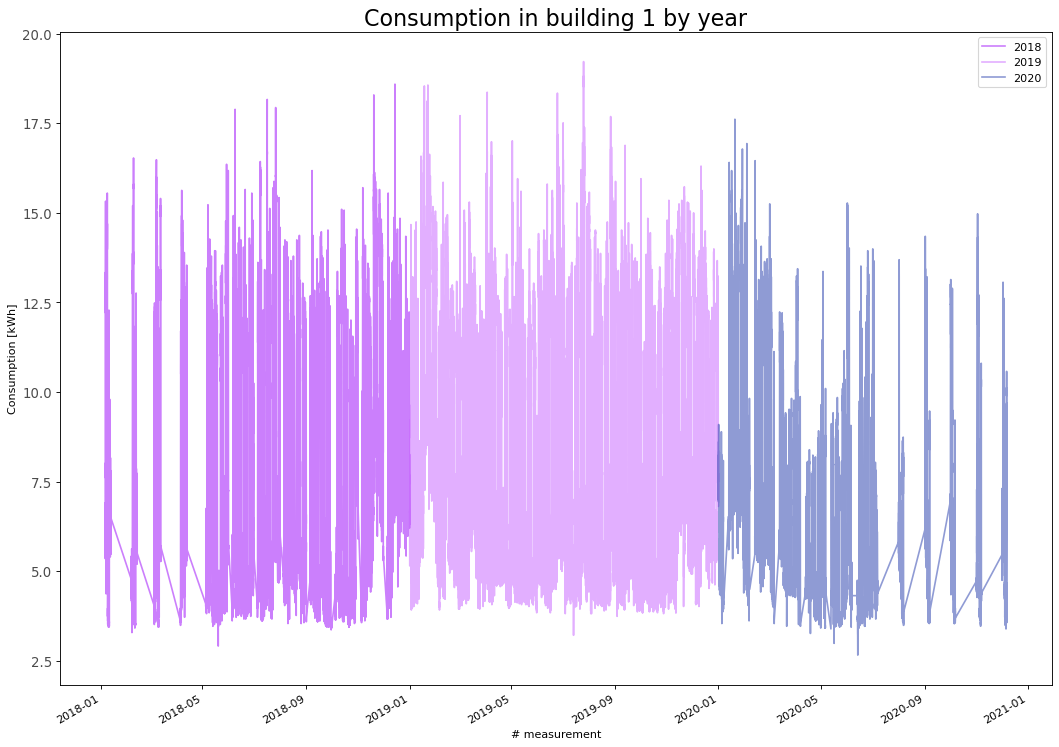

In [13]:
holidata.index = pd.to_datetime(holidata.index)
years = holidata.index.year.unique()
# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False) 

# Draw Plot
fig, ax = plt.subplots(figsize=(16,12), dpi= 80)
for i,year in enumerate(years):
        data_temp=holidata.loc[holidata.index.year==year, :]
        data_temp.plot(y='Valeur', use_index=True, color=mycolors[i], label=year, ax=ax, alpha=0.5)

# Decoration
plt.gca().set(ylabel='Consumption [kWh]', xlabel='# measurement')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Consumption in building 1 by year", fontsize=20)
plt.show()

<AxesSubplot:xlabel='Date'>

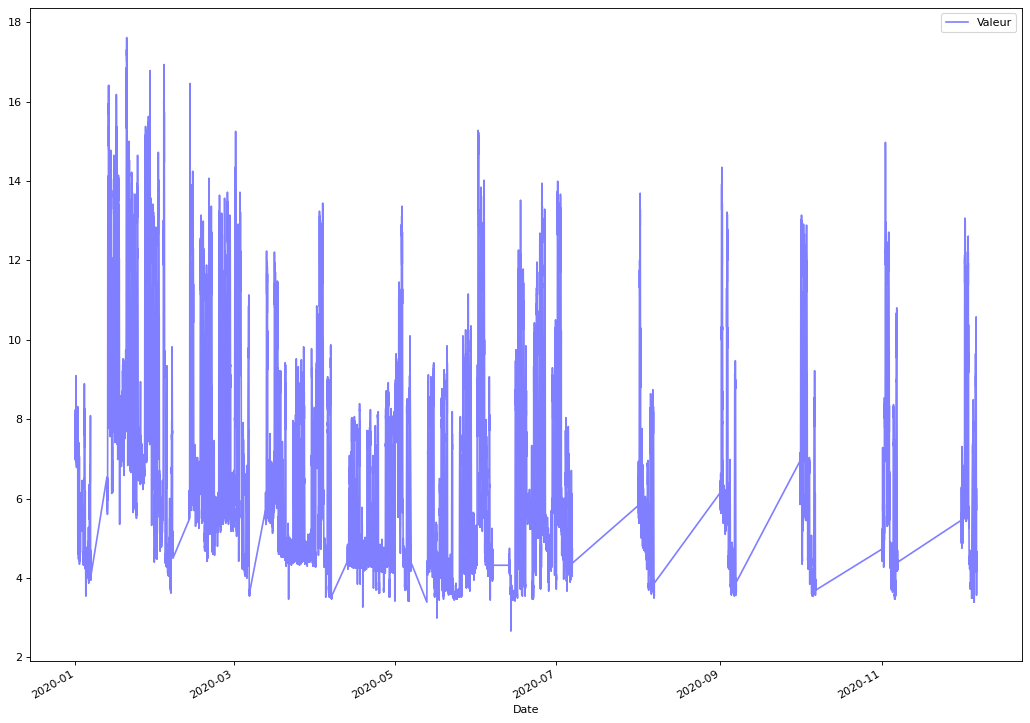

In [14]:
fig, ax = plt.subplots(figsize=(16,12), dpi= 80)
data_temp=holidata.loc[holidata.index.year==2020, :]
data_temp.plot(y='Valeur', use_index=True, color='b', ax=ax, alpha=0.5)


In [49]:
# Deep learning: 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger


class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        # Setting up early stopping
        earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)
        
        # Saving training history
        csv_logger = CSVLogger('training_B2_25ep.log', separator=',', append=False)
        
        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False,
            #'callbacks': [earlyStop, csv_logger]
            'callbacks': [csv_logger]

        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat    

In [50]:
deep_learner = DeepModelTS(
data = holidata,
Y_var = 'Valeur',
lag = 34,
LSTM_layer_depth = 50,
epochs = 30,
batch_size = 128,
train_test_split = 0.15
)

In [51]:
# Fitting the model
model = deep_learner.LSTModel()

Epoch 1/30
504/504 [==============================] - 27s 54ms/step - loss: 3.3248 - val_loss: 0.2113
Epoch 2/30
504/504 [==============================] - 27s 54ms/step - loss: 0.2998 - val_loss: 0.1992
Epoch 3/30
504/504 [==============================] - 26s 52ms/step - loss: 0.2929 - val_loss: 0.1933
Epoch 4/30
504/504 [==============================] - 26s 51ms/step - loss: 0.2904 - val_loss: 0.1991
Epoch 5/30
504/504 [==============================] - 28s 56ms/step - loss: 0.2883 - val_loss: 0.1998
Epoch 6/30
504/504 [==============================] - 29s 58ms/step - loss: 0.2892 - val_loss: 0.2034
Epoch 7/30
504/504 [==============================] - 27s 53ms/step - loss: 0.2882 - val_loss: 0.1995
Epoch 8/30
504/504 [==============================] - 30s 59ms/step - loss: 0.2867 - val_loss: 0.1978
Epoch 9/30
504/504 [==============================] - 28s 55ms/step - loss: 0.2856 - val_loss: 0.1968
Epoch 10/30
504/504 [==============================] - 28s 56ms/step - loss: 0.284

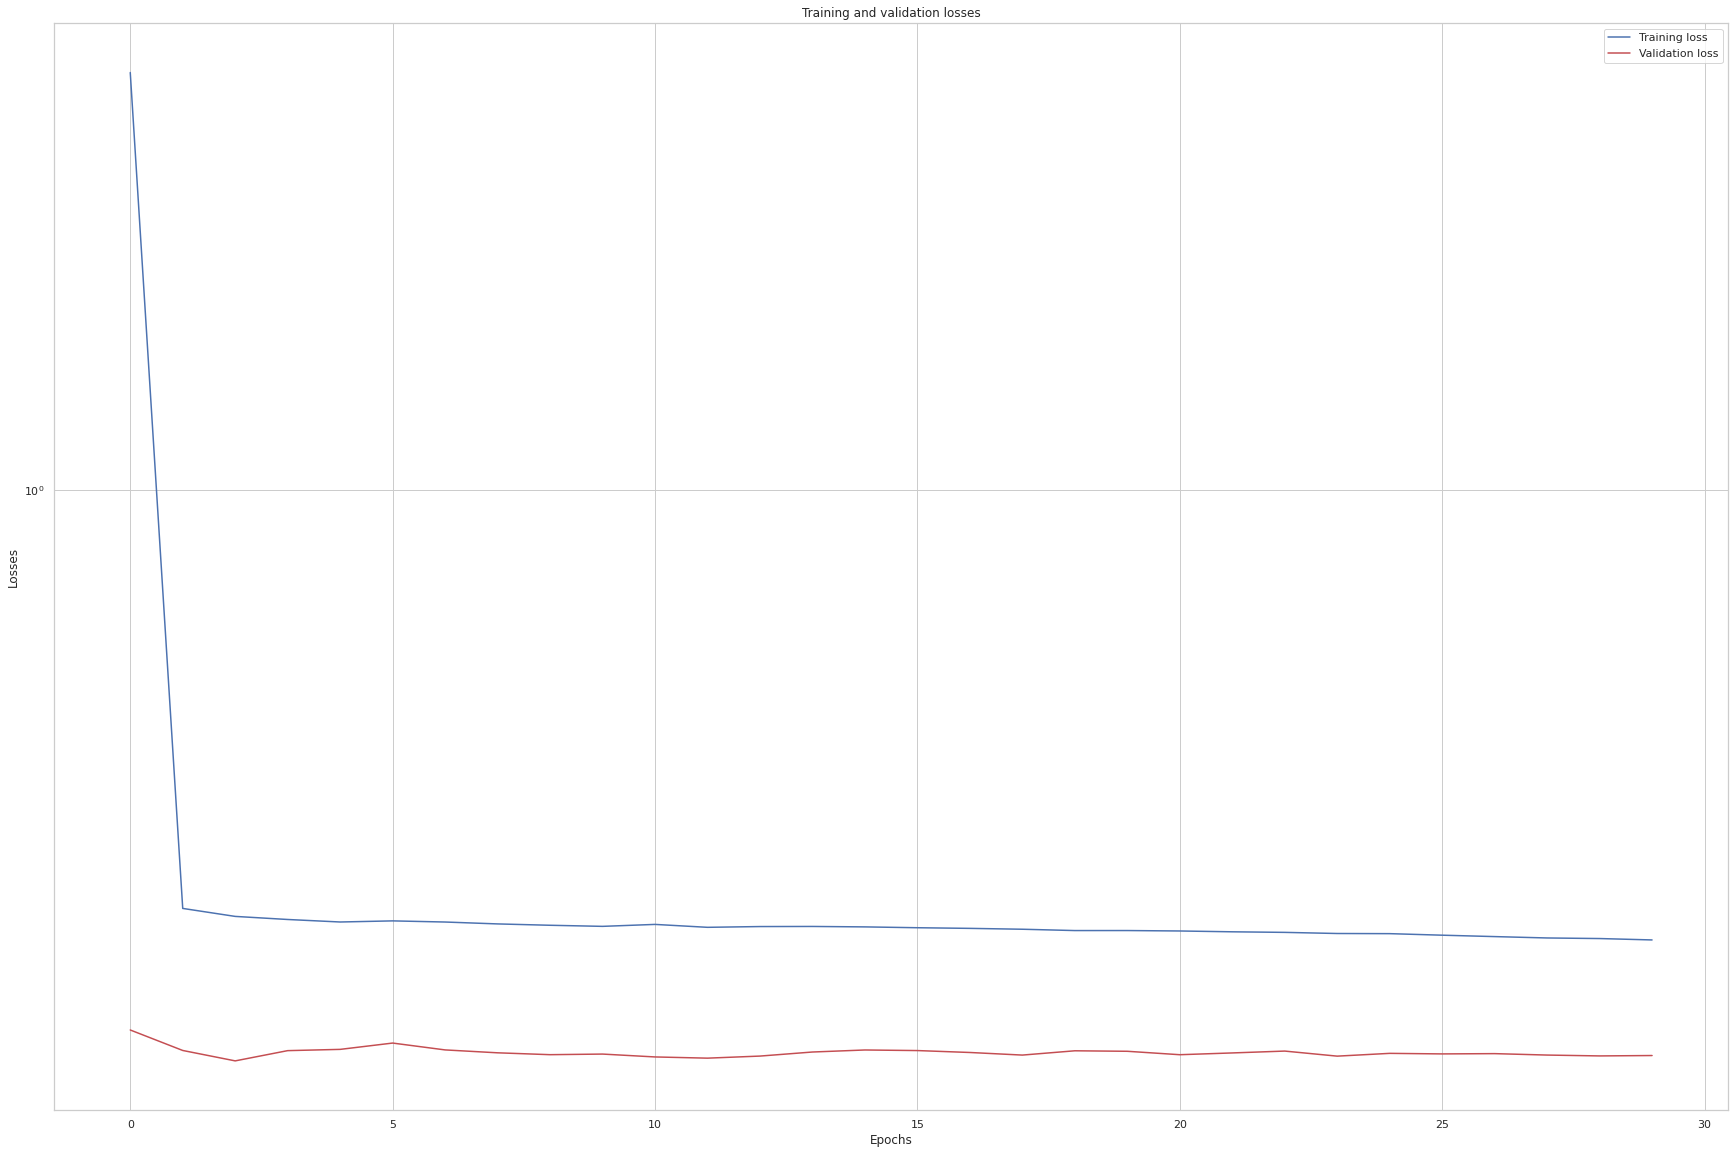

In [52]:
def plot_train_history(model):
    '''
    Convergence plots to have an idea on how the training performs
    '''
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']

    plt.figure()
    plt.plot(range(len(loss)), loss, 'b', label='Training loss')
    plt.plot(range(len(val_loss)), val_loss, 'r', label='Validation loss')
    plt.yscale("log")
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Training and validation losses')
    plt.legend()
    plt.show()  
plot_train_history(model)

In [53]:
model_json = model.to_json()
with open("model_B4.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_B4.h5")

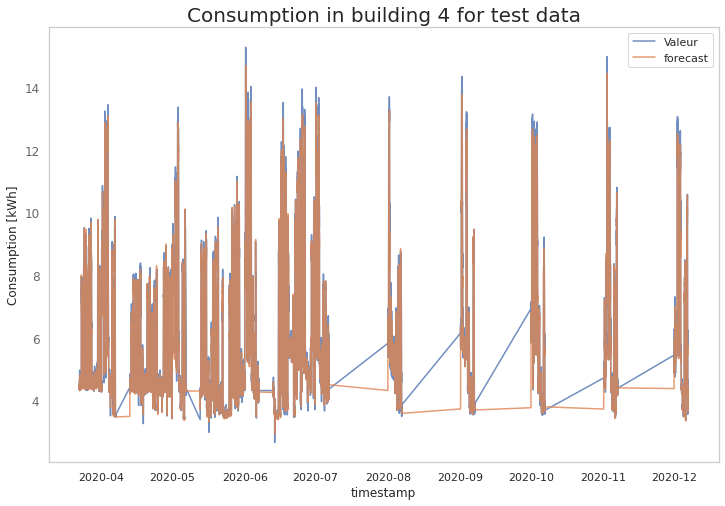

In [54]:
yhat = deep_learner.predict()# Constructing the forecast dataframe
#fc = holidata.nlargest(len(yhat),columns='Datetime').copy()
fc = holidata.tail(len(yhat)).copy()
fc['forecast'] = yhat
#fc['Datetime'] = pd.to_datetime(fc['Datetime'])
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['Valeur', 'forecast']:  
    plt.plot('Datetime',dtype,data=fc,label=dtype,alpha=0.8)
plt.legend()
plt.grid()

plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Consumption in building 4 for test data", fontsize=20)

plt.show()

In [61]:
fc = fc.set_index('Datetime', drop=False)
fc.index = pd.to_datetime(fc.index)
fc.tail()

,Valeur,Datetime,working day,forecast
Datetime,,,,
2020-12-06 22:45:00,4.446,2020-12-06 22:45:00,False,4.205518
2020-12-06 23:00:00,4.320,2020-12-06 23:00:00,False,4.302075
2020-12-06 23:15:00,4.320,2020-12-06 23:15:00,False,4.305830
2020-12-06 23:30:00,4.471,2020-12-06 23:30:00,False,4.302599
2020-12-06 23:45:00,4.320,2020-12-06 23:45:00,False,4.355748


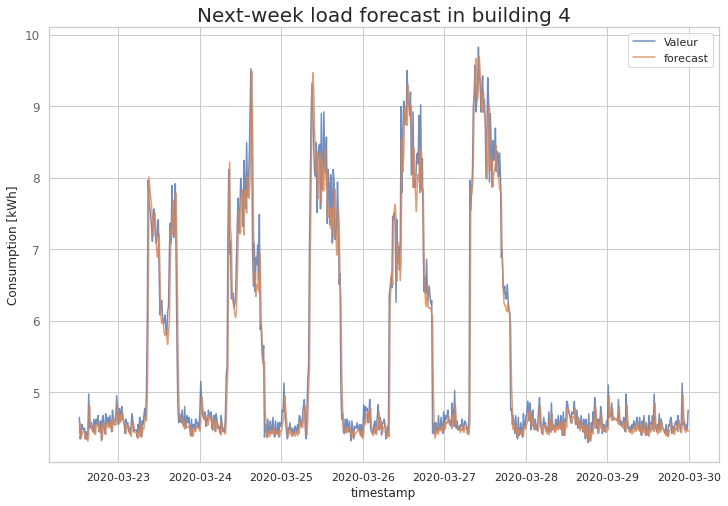

In [62]:
plt.figure(figsize=(12, 8))
ax.grid(b=True, which='major', color='b', linestyle='-')
for dtype in ['Valeur', 'forecast']:  
    plt.plot('Datetime',dtype,data=fc[:'2020-03-29'],label=dtype, alpha=0.8)
    #plt.plot('Datetime',dtype,data=fc[:'2019-02-01'],label=dtype,alpha=0.8)
plt.legend()

plt.rcParams.update({'figure.figsize': (30,20)})
plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Next-week load forecast in building 4", fontsize=20)
plt.show()

In [63]:
#need to MAPE, RMSE and R-correlation factor
expected = fc.loc[:'2020-03-29','Valeur']
#expected = fc['Valeur']
predictions = fc.loc[:'2020-03-29','forecast']
#predictions = fc['forecast']
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]

In [64]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(expected, predictions)
rmse = sqrt(mse)
print('RMSE: %f [kWh]' % rmse)

RMSE: 0.409821 [kWh]


In [65]:
def mean_absolute_percentage_error(y_true, y_pred): 
    #y_true, y_pred = check_array(y_true, y_pred)
    np.isfinite(expected).any()
    np.isfinite(predictions).any()
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(np.array(expected), np.array(predictions))
print('MAPE: %f %%' % mape)

MAPE: 4.036206 %


/home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Text(0, 0.5, 'MAPE %')]

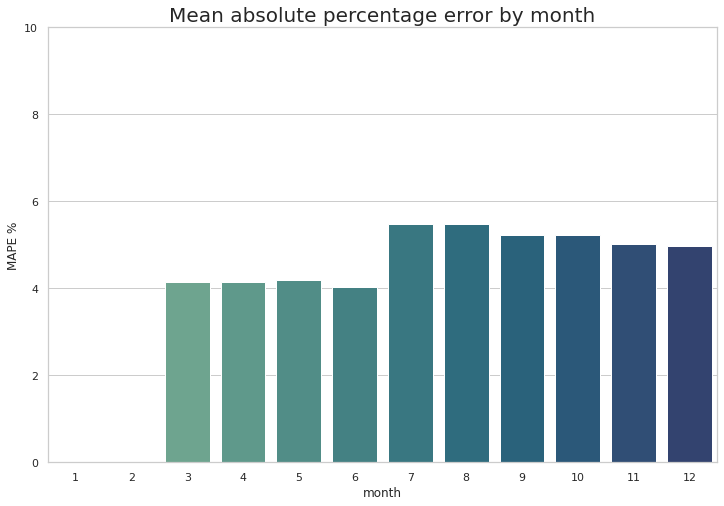

In [66]:
mape = []
for i in range(1,13):
    expected = fc['Valeur'].loc[fc.index.month == i]
    predictions = fc['forecast'].loc[fc.index.month == i]
    mape.append(mean_absolute_percentage_error(np.array(expected), np.array(predictions)))
data_tuples = list(zip(list(range(1,13)), mape))
months = pd.DataFrame(data_tuples, columns=['month','MAPE'])
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")
#sns.color_palette('rocket', as_cmap=True)
plt.title("Mean absolute percentage error by month", fontsize=20)
ax = sns.barplot(x='month', y='MAPE', data = months, palette='crest')
ax.set_ylim([0,10])
ax.set(ylabel='MAPE %')